In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from collections import Counter, defaultdict
import random
import argparse
import seaborn as sns
import re

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024 ** 2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (
                start_mem - end_mem) / start_mem))
    return df

In [3]:
train = pd.read_csv('../data/train.csv')
train = reduce_mem_usage(train)

# test = pd.read_csv('../data/test.csv')
# test = reduce_mem_usage(test)

Mem. usage decreased to 23.84 Mb (79.2% reduction)


In [4]:
from bokeh.models import Panel, Tabs
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.layouts import gridplot
# https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-ion-switching
output_notebook()

def get_plots(df, col="signal", title="Signal change over time for first 5 seconds in the train data"):
    p = figure(plot_width=1000, plot_height=350, x_axis_type="datetime", title=title)
    p.title.align = "center"
    p.line(df['time']*1000, df[col], color='navy', alpha=0.5)
    return p

temp_df = train.iloc[:50000]
p1 = get_plots(temp_df)
p2 = get_plots(temp_df, "open_channels", "Open channels change over time for first 5 seconds in train data")
show(gridplot([p1,p2], ncols=1, plot_width=800, plot_height=400, toolbar_location=None))

Loading BokehJS ...

In [5]:
output_notebook()
def make_plot(title, hist, edges, xlabel):
    p = figure(title=title, tools='', background_fill_color="#fafafa")
    p.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:],
           fill_color="#1E90FF", line_color="white", alpha=0.5)

    p.y_range.start = 0
    p.xaxis.axis_label = 'Signal value'
    p.yaxis.axis_label = 'Probability'
    p.grid.grid_line_color="white"
    p.title.align = "center"
    return p

all_plots = []
for target_value in range(11):
    temp_df = train[train["open_channels"]==target_value]
    hist, edges = np.histogram(temp_df["signal"].values, density=True, bins=50)
    all_plots.append(make_plot(f"Signal distribution when number of open channels is {target_value}", hist, edges, target_value))
    
show(gridplot(all_plots, ncols=1, plot_width=800, plot_height=400, toolbar_location=None))

Loading BokehJS ...

- Target classes 0 to 3 exhibit similar distribution
- Target classes 4 and 5 are similar
- Target classes 6 to 10 exhibit similar distribution. Very interesting patterns indeed!

In [8]:
# https://www.kaggle.com/artgor/eda-and-model-f1-optimization

train['batch'] = 0
for i in range(0, 10):
    train.iloc[i * 500000: 500000 * (i + 1), 3] = i

In [9]:
train[:3]

,time,signal,open_channels,batch
0,0.0001,-2.759766,0,0
1,0.0002,-2.855469,0,0
2,0.0003,-2.408203,0,0


In [27]:
test['batch'] = 0
for i in range(0, 4):
    test.loc[i * 500000: 500000 * (i + 1), 'batch'] = i

In [28]:
test[:3]

,time,signal,batch
0,500.0,-2.650391,0
1,500.0,-2.849609,0
2,500.0,-2.859375,0


In [4]:
from featexp import get_univariate_plots
from featexp import univariate_plotter
from featexp import get_trend_stats

                                           Plots for signal                                           


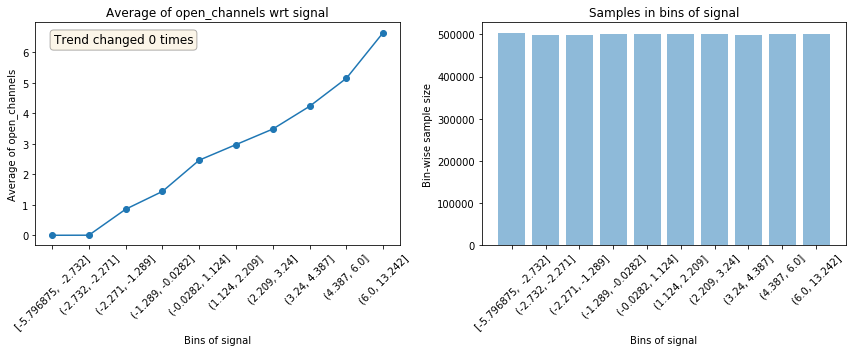

--------------------------------------------------------------------------------------------------------------




In [59]:
get_univariate_plots(data=train, target_col='open_channels', features_list=['signal'])

In [68]:
train.head()

,time,signal,open_channels,batch,macd,target
0,0.0001,-2.759766,0,0,NaN,0
1,0.0002,-2.855469,0,0,NaN,0
2,0.0003,-2.408203,0,0,NaN,0
3,0.0004,-3.140625,0,0,NaN,0
4,0.0005,-3.152344,0,0,NaN,0


                                           Plots for signal                                           


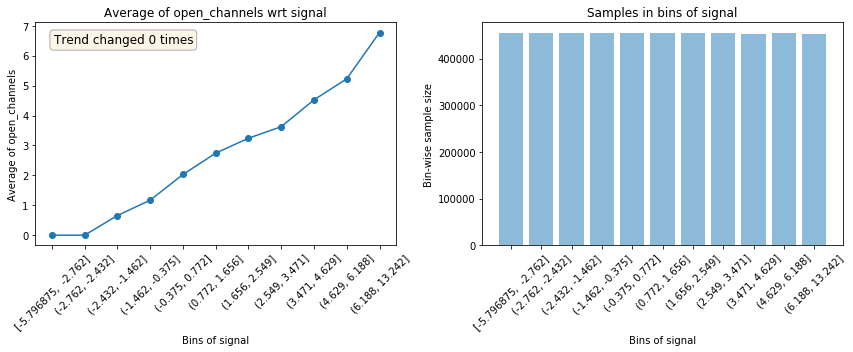

--------------------------------------------------------------------------------------------------------------




In [79]:
binned_train = univariate_plotter(data=train, target_col='open_channels', feature='signal', bins=11)

In [4]:
binned_train = pd.read_csv("binned_train.csv")
# binned_train.to_csv("binned_train.csv")
binned_train

,Unnamed: 0,signal,Samples_in_bin,open_channels_mean,signal_mean
0,0,"[-5.796875, -2.762]",454807,0.002045,-2.9470
1,1,"(-2.762, -2.432]",454547,0.001751,-2.6130
2,2,"(-2.432, -1.462]",454982,0.657936,-1.8660
3,3,"(-1.462, -0.375]",453994,1.172178,-1.0020
4,4,"(-0.375, 0.772]",454700,2.029294,0.1583
5,5,"(0.772, 1.656]",454568,2.741990,1.1560
6,6,"(1.656, 2.549]",454946,3.241018,2.1250
7,7,"(2.549, 3.471]",454830,3.626832,3.0490
8,8,"(3.471, 4.629]",453903,4.522806,4.0160
9,9,"(4.629, 6.188]",454889,5.226158,5.3870


In [5]:
fn = lambda x: np.float(re.findall("[-+]?\d*\.\d+|\d+", x.split(",")[0])[0]) 
bins = binned_train.signal.apply(fn).astype(float).values
bins = np.append(bins, 13.242)
bins

array([-5.796875, -2.762   , -2.432   , -1.462   , -0.375   ,  0.772   ,
        1.656   ,  2.549   ,  3.471   ,  4.629   ,  6.188   , 13.242   ])

In [157]:
train['signal_binned'] = pd.cut(train.signal, bins=bins, labels=False)

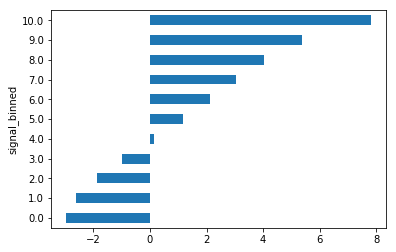

In [163]:
train.groupby("signal_binned")["signal"].mean().plot(kind='barh')

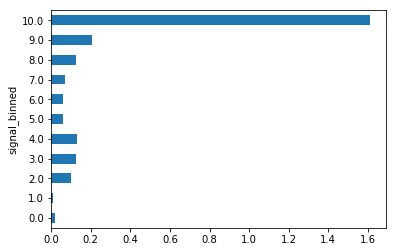

In [192]:
train.groupby("signal_binned")["signal"].var().plot(kind='barh')

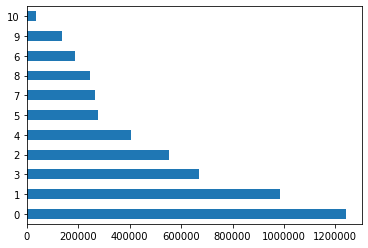

In [44]:
train['open_channels'].value_counts().plot(kind='barh')

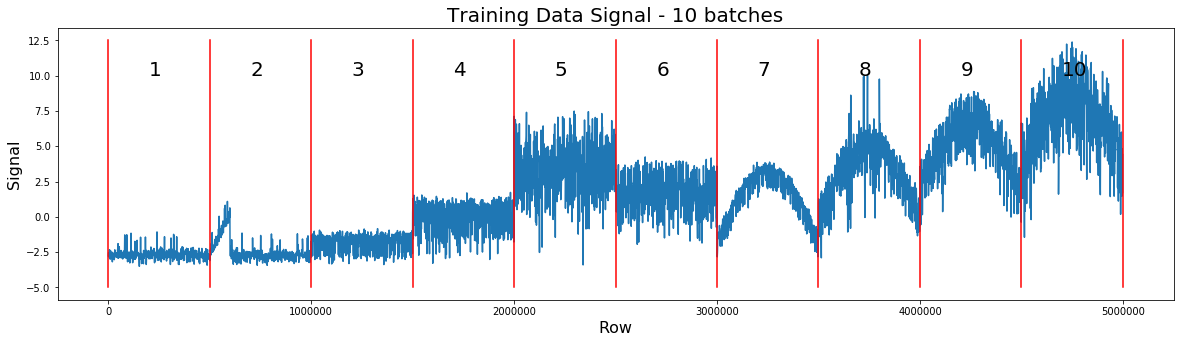

In [6]:
plt.figure(figsize=(20,5)); res = 1000
plt.plot(range(0,train.shape[0],res),train.signal[0::res])
for i in range(11): plt.plot([i*500000,i*500000],[-5,12.5],'r')
for j in range(10): plt.text(j*500000+200000,10,str(j+1),size=20)
plt.xlabel('Row',size=16); plt.ylabel('Signal',size=16); 
plt.title('Training Data Signal - 10 batches',size=20)
plt.show()

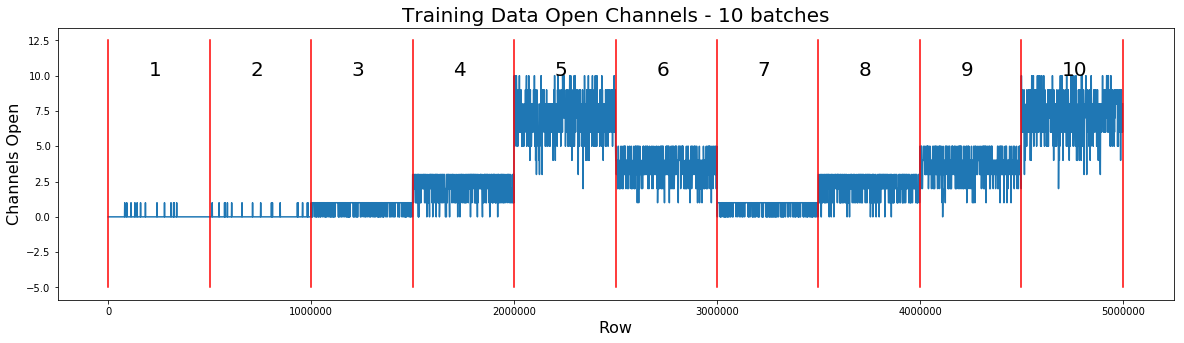

In [7]:
plt.figure(figsize=(20,5)); res = 1000
plt.plot(range(0,train.shape[0],res),train.open_channels[0::res])
for i in range(11): plt.plot([i*500000,i*500000],[-5,12.5],'r')
for j in range(10): plt.text(j*500000+200000,10,str(j+1),size=20)
plt.xlabel('Row',size=16); plt.ylabel('Channels Open',size=16); 
plt.title('Training Data Open Channels - 10 batches',size=20)
plt.show()

#########################
### Random 2050524 to 2055524
#########################


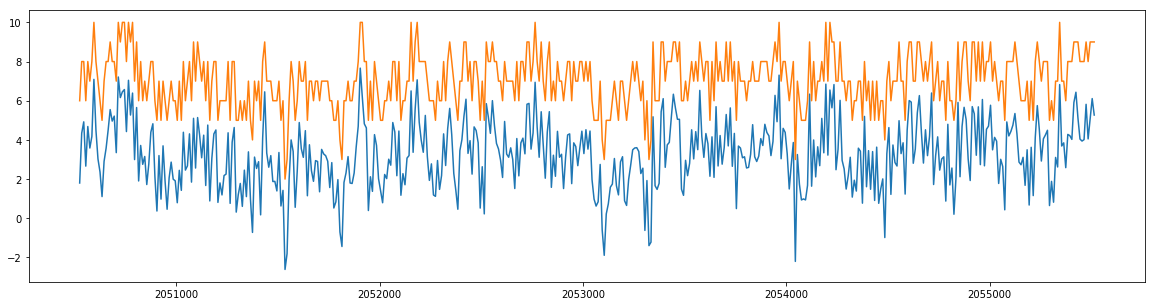

#########################
### Random 4654754 to 4659754
#########################


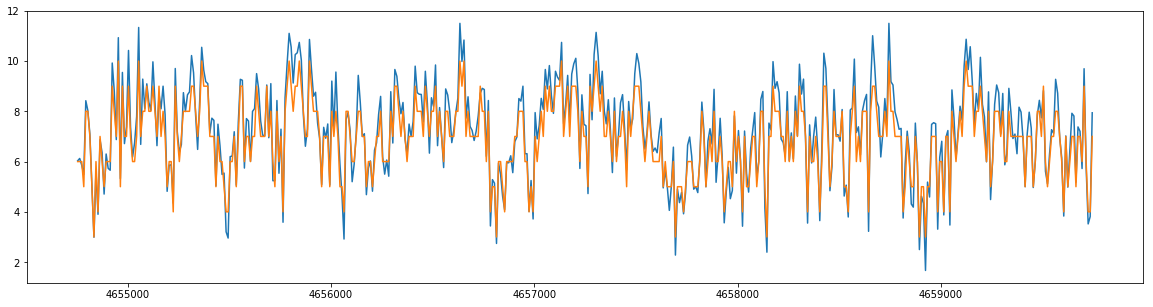

In [9]:
for k in range(2):
    a = int( np.random.uniform(0,train.shape[0]-50000) )
    b=a+5000; res=10
    print('#'*25)
    print('### Random %i to %i'%(a,b))
    print('#'*25)
    plt.figure(figsize=(20,5))
    plt.plot(range(a,b,res),train.signal[a:b][0::res])
    plt.plot(range(a,b,res),train.open_channels[a:b][0::res])
    plt.show()

Text(0.5, 1.0, 'Test Data Signal - 4 batches - 10 subsamples')

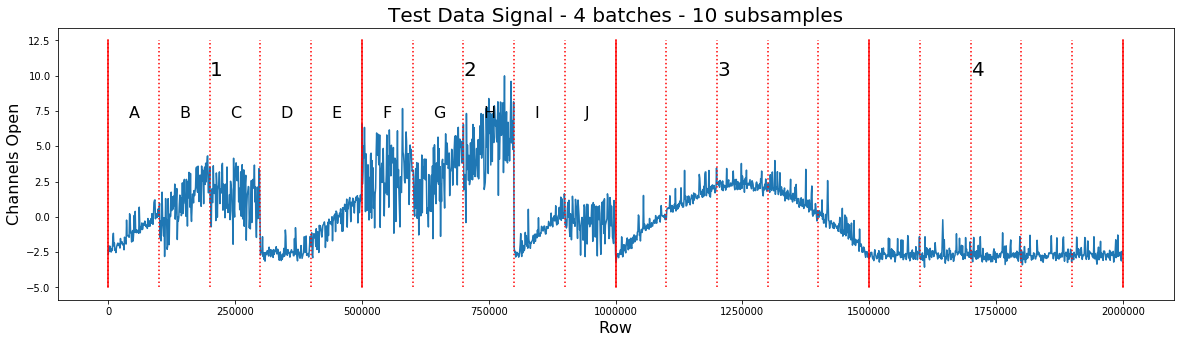

In [16]:
plt.figure(figsize=(20,5))
res = 1000; let = ['A','B','C','D','E','F','G','H','I','J']
plt.plot(range(0,test.shape[0],res),test.signal[0::res])
for i in range(5): plt.plot([i*500000,i*500000],[-5,12.5],'r')
for j in range(21): plt.plot([j*100000,j*100000],[-5,12.5],'r:')
for k in range(4): plt.text(k*500000+200000,10,str(k+1),size=20)
for k in range(10): plt.text(k*100000+40000,7,let[k],size=16)
plt.xlabel('Row',size=16); plt.ylabel('Channels Open',size=16); 
plt.title('Test Data Signal - 4 batches - 10 subsamples',size=20)

In [31]:
batch = 3; a = 500000*(batch-1); b = 500000*batch
batch = 7; c = 500000*(batch-1); d = 500000*batch
X = np.concatenate([train.signal.values[a:b],train.signal.values[c:d]]).reshape((-1,1))

In [33]:
X.shape

(1000000, 1)

In [176]:
def MACD(df, period1, period2, periodSignal):
    EMA1 = pd.DataFrame.ewm(df, span=period1).mean()
    EMA2 = pd.DataFrame.ewm(df, span=period2).mean()
    MACD = EMA1-EMA2
    
    Signal = pd.DataFrame.ewm(MACD,periodSignal).mean()
    
    Histogram = MACD-Signal
    
    return Histogram, Signal

def stochastics_oscillator(df,period):
    l, h = pd.DataFrame.rolling(df, period).min(), pd.DataFrame.rolling(df, period).max()
    k = 100 * (df - l) / (h - l)
    return k

In [178]:
h, s = MACD(train.signal, 6, 13, 3)

In [41]:
train.query("batch==8").open_channels.value_counts()

4    185846
3    148234
5     93013
2     60061
1     11879
0       967
Name: open_channels, dtype: int64

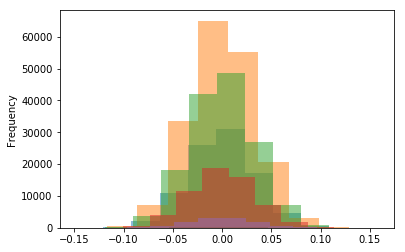

In [48]:
MACD(train.query("(batch==8) & (open_channels==5)").signal, 12, 26, 9).plot(kind='hist', alpha=0.5)
MACD(train.query("(batch==8) & (open_channels==4)").signal, 12, 26, 9).plot(kind='hist', alpha=0.5)
MACD(train.query("(batch==8) & (open_channels==3)").signal, 12, 26, 9).plot(kind='hist', alpha=0.5)
MACD(train.query("(batch==8) & (open_channels==2)").signal, 12, 26, 9).plot(kind='hist', alpha=0.5)
MACD(train.query("(batch==8) & (open_channels==1)").signal, 12, 26, 9).plot(kind='hist', alpha=0.5)
MACD(train.query("(batch==8) & (open_channels==0)").signal, 12, 26, 9).plot(kind='hist', alpha=0.5)

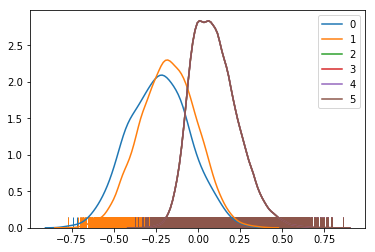

In [55]:
# train['macd'] = MACD(train.query("batch==8").signal, 12, 26, 9)

och_0 = train.loc[train['open_channels'] == 0]
och_1 = train.loc[train['open_channels'] == 1]
och_2 = train.loc[train['open_channels'] == 2]
och_2 = train.loc[train['open_channels'] == 3]
och_2 = train.loc[train['open_channels'] == 4]
och_2 = train.loc[train['open_channels'] == 5]

sns.distplot(och_0[['macd']], hist=False, rug=True, label='0')
sns.distplot(och_1[['macd']], hist=False, rug=True, label='1')
sns.distplot(och_2[['macd']], hist=False, rug=True, label='2')#
sns.distplot(och_2[['macd']], hist=False, rug=True, label='3')#
sns.distplot(och_2[['macd']], hist=False, rug=True, label='4')#
sns.distplot(och_2[['macd']], hist=False, rug=True, label='5')#

In [208]:
train[:2]

,time,signal,open_channels,batch,signal_binned
0,0.0001,-2.759766,0,0,1.0
1,0.0002,-2.855469,0,0,0.0


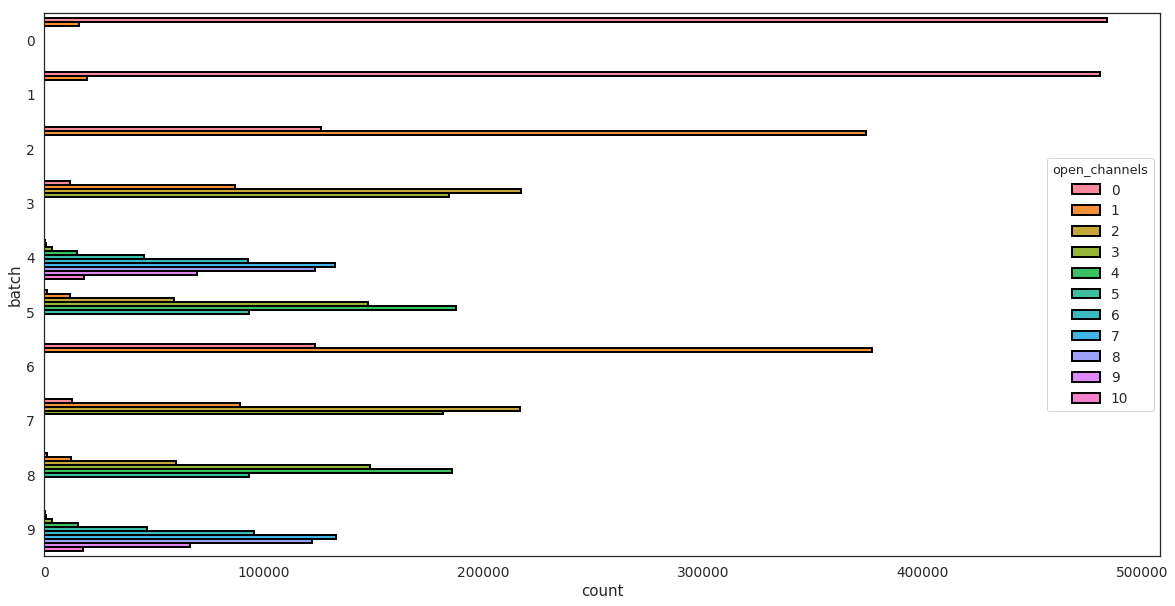

In [215]:
plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams['font.family'] = "serif"

plt.rcParams['font.family'] = 'Times New Roman'
#sns.set_style({'font.family': 'Helvetica'})
sns.set(style="white",font_scale=1.25)
num_categories = train.open_channels.unique().size
p = sns.countplot(data=train,
                  y = 'batch',
                  hue = 'open_channels',
                  saturation=1,
#                   xerr=3*np.arange(num_categories),
                  edgecolor=(0,0,0),
                  linewidth=2)

In [206]:
pd.crosstab(train.batch, train.open_channels)

open_channels,0,1,2,3,4,5,6,7,8,9,10
batch,,,,,,,,,,,
0,484134,15866,0,0,0,0,0,0,0,0,0
1,480662,19338,0,0,0,0,0,0,0,0,0
2,126004,373996,0,0,0,0,0,0,0,0,0
3,11778,86930,216883,184409,0,0,0,0,0,0,0
4,2,57,526,3426,14625,45145,92779,132319,123243,69650,18228
5,956,11732,59234,147333,187582,93163,0,0,0,0,0
6,123195,376805,0,0,0,0,0,0,0,0,0
7,12454,89193,216659,181694,0,0,0,0,0,0,0
8,967,11879,60061,148234,185846,93013,0,0,0,0,0


In [216]:
def add_bathing_to_data(df : pd.DataFrame) -> pd.DataFrame :
    batches = df.shape[0] // 500000
    df['batch'] = 0
    for i in range(batches):
        idx = np.arange(i*500000, (i+1)*500000)
        df.loc[idx, 'batch'] = i + 1
    return df

def p5( x : pd.Series) -> pd.Series : return x.quantile(0.05)
def p95(x : pd.Series) -> pd.Series : return x.quantile(0.95)

In [226]:
train.groupby(['batch'])[['signal','open_channels']].agg(['min', 'max', 'median', p5, p95])

signal                                           open_channels      \
            min        max    median        p5        p95           min max   
batch                                                                         
0     -3.851562   5.000000 -2.708984 -3.125000  -2.208984             0   1   
1     -3.902344   2.222656 -2.648438 -3.105469  -0.396484             0   1   
2     -3.910156  -0.352539 -1.610352 -2.945312  -1.130859             0   1   
3     -3.707031   2.240234 -0.134033 -1.783203   1.254883             0   3   
4     -5.796875   8.609375  3.392578  0.281738   6.152344             0  10   
5     -3.818359   4.792969  1.917969 -0.502930   3.617188             0   5   
6     -3.503906   4.476562  1.673828 -1.483398   3.548828             0   1   
7     -3.496094  10.000000  3.228516 -0.272217   5.902344             0   3   
8     -3.203125   9.492188  4.976562  1.330078   7.933594             0   5   
9     -3.908203  13.242188  6.601562  2.376953  10.273438             1  10   

                     
      median p5 p95  
batch                
0          0  0   0  
1          0  0   0  
2          1  0   1  
3          2  1   3  
4          7  5   9  
5          4  2   5  
6          1  0   1  
7          2  1   3  
8          4  2   5  
9          7  5   9

# Model

In [3]:
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import xgboost as xgb
from catboost import Pool, CatBoostRegressor
import gc
import joblib

In [5]:
train = pd.read_csv('../data/train.csv')
train = reduce_mem_usage(train)

test = pd.read_csv('../data/test.csv')
test = reduce_mem_usage(test)

# bins = pd.read_csv('')

Mem. usage decreased to 23.84 Mb (79.2% reduction)
Mem. usage decreased to  7.63 Mb (75.0% reduction)


In [4]:
def features(df, bins=None):
    df = df.sort_values(by=['time']).reset_index(drop=True)
    df.index = ((df.time * 10_000) - 1).values
    df['batch'] = df.index // 25_000
    df['batch_index'] = df.index  - (df.batch * 25_000)
    df['batch_slices'] = df['batch_index']  // 2500
    df['batch_slices2'] = df.apply(lambda r: '_'.join([str(r['batch']).zfill(3), str(r['batch_slices']).zfill(3)]), axis=1)
    
    for c in ['batch','batch_slices2']:
        d = {}
        d['mean'+c] = df.groupby([c])['signal'].mean()
        d['median'+c] = df.groupby([c])['signal'].median()
        d['max'+c] = df.groupby([c])['signal'].max()
        d['min'+c] = df.groupby([c])['signal'].min()
        d['std'+c] = df.groupby([c])['signal'].std()
        d['mean_abs_chg'+c] = df.groupby([c])['signal'].apply(lambda x: np.mean(np.abs(np.diff(x))))
        d['abs_max'+c] = df.groupby([c])['signal'].apply(lambda x: np.max(np.abs(x)))
        d['abs_min'+c] = df.groupby([c])['signal'].apply(lambda x: np.min(np.abs(x)))
        d['range'+c] = d['max'+c] - d['min'+c]
        d['maxtomin'+c] = d['max'+c] / d['min'+c]
        d['abs_avg'+c] = (d['abs_min'+c] + d['abs_max'+c]) / 2
        for v in d:
            df[v] = df[c].map(d[v].to_dict())

    
    #add shifts
    df['signal_shift_+1'] = [0,] + list(df['signal'].values[:-1])
    df['signal_shift_-1'] = list(df['signal'].values[1:]) + [0]
    for i in df[df['batch_index']==0].index:
        df['signal_shift_+1'][i] = np.nan
    for i in df[df['batch_index']==49999].index:
        df['signal_shift_-1'][i] = np.nan

    for c in [c1 for c1 in df.columns if c1 not in ['time', 'signal', 'open_channels', 'batch', 'batch_index', 'batch_slices', 'batch_slices2']]:
        df[c+'_msignal'] = df[c] - df['signal']
        
    return reduce_mem_usage(df)

def MacroF1Metric(preds, dtrain):
    labels = dtrain.get_label()
    preds = np.round(np.clip(preds, 0, 10)).astype(int)
    score = f1_score(labels, preds, average = 'macro')
    return ('MacroF1Metric', score, True)

# def seed_everything(seed : int) -> NoReturn :
#     rn.seed(seed)
#     np.random.seed(seed)
#     os.environ['PYTHONHASHSEED'] = str(seed)
#     tf.random.set_seed(seed)

In [7]:
%%time
train = features(train)
test = features(test)

Mem. usage decreased to 643.73 Mb (68.5% reduction)
Mem. usage decreased to 232.70 Mb (71.5% reduction)
CPU times: user 3min 4s, sys: 3.67 s, total: 3min 7s
Wall time: 3min 7s


In [5]:
# joblib.dump(train, "train.pkl")
# joblib.dump(test, "test.pkl")

train = joblib.load("train.pkl")
test = joblib.load("test.pkl")

In [297]:
# train['signal_binned'] = pd.cut(train.signal, bins=bins, labels=False)
# test['signal_binned'] = pd.cut(test.signal, bins=bins, labels=False)

In [67]:
# target = pd.read_csv('../data/train.csv', usecols=['open_channels'])
# x1, x2, y1, y2 = train_test_split(train, target, test_size=0.3, random_state=100)

In [6]:
col = train.columns.difference(['time', 'open_channels', 'batch', 'batch_index', 'batch_slices', 'batch_slices2']).tolist()
x1, x2, y1, y2 = train_test_split(train[col], train['open_channels'], test_size=0.3, random_state=100)
target = train['open_channels']
train = train[col]

In [10]:
%%time
params = {'learning_rate': 0.1, 'max_depth': -1, 'num_leaves':2**7+1, 'metric': 'rmse', 'random_state': 7, 'n_jobs':-1, 'sample_fraction':0.33} 
model = lgb.train(params, lgb.Dataset(x1, y1), 22222,  lgb.Dataset(x2, y2), verbose_eval=0, early_stopping_rounds=250, feval=MacroF1Metric)
preds_lgb = (model.predict(test[col], num_iteration=model.best_iteration)).astype(np.float16)
oof_lgb = (model.predict(train, num_iteration=model.best_iteration)).astype(np.float16)
gc.collect()

CPU times: user 50min 16s, sys: 20.3 s, total: 50min 36s
Wall time: 11min 25s


426

In [8]:
# np.save("preds_lgb.npy", preds_lgb)
preds_lgb = np.load("preds_lgb.npy")

In [7]:
%%time
params = {'colsample_bytree': 0.375,'learning_rate': 0.1,'max_depth': 10, 'subsample': 1, 'objective':'reg:squarederror',
          'eval_metric':'rmse', 'n_estimators':22222,   'tree_method':'gpu_hist',}
train_set = xgb.DMatrix(x1, y1)
val_set = xgb.DMatrix(x2, y2)
model = xgb.train(params, train_set, num_boost_round=2222, evals=[(train_set, 'train'), (val_set, 'val')], 
                         verbose_eval=0, early_stopping_rounds=250)
preds_xgb = model.predict(xgb.DMatrix(test[col]), ntree_limit=model.best_ntree_limit)
oof_xgb = (model.predict(xgb.DMatrix(train), ntree_limit=model.best_ntree_limit)).astype(np.float16)
del train_set, val_set; gc.collect()

CPU times: user 46.1 s, sys: 2.41 s, total: 48.5 s
Wall time: 48.6 s


87

In [9]:
model = CatBoostRegressor(task_type = 'GPU', iterations=22222, learning_rate=0.1, random_seed = 100, depth=7, eval_metric='RMSE')
train_dataset = Pool(x1,  y1)          
eval_dataset = Pool(x2,  y2)
model.fit(train_dataset, eval_set=eval_dataset, verbose=0, early_stopping_rounds=250)
preds_cb = (model.predict(test[col])).astype(np.float16)
oof_cb = (model.predict(train)).astype(np.float16)
del train_dataset, eval_dataset, model; gc.collect()

0

In [10]:
final_preds = 0.4 * preds_lgb + 0.4 * preds_xgb + 0.2 * preds_cb 
# final_oof   = 0.4 * oof_lgb + 0.4 * oof_xgb + 0.2 * oof_cb 

In [24]:
from functools import partial
import scipy as sp
class OptimizedRounder(object):

    def __init__(self):
        self.coef_ = 0

    def loss(self, coef, X, y):
        X_p = pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
        return -metrics.f1_score(y, X_p, average = 'macro')

    def fit(self, X, y):
        loss_partial = partial(self.loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')

    def predict(self, X, coef):
        return (pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])).astype(np.int8)

    def coefficients(self):
        return self.coef_['x']

In [25]:
def optimize_predictions(preds, coeffs):
    
    preds[preds <= coeffs[0]] = 0
    preds[np.where(np.logical_and(preds > coeffs[0], preds <= coeffs[1]))] = 1
    preds[np.where(np.logical_and(preds > coeffs[1], preds <= coeffs[2]))] = 2
    preds[np.where(np.logical_and(preds > coeffs[2], preds <= coeffs[3]))] = 3
    preds[np.where(np.logical_and(preds > coeffs[3], preds <= coeffs[4]))] = 4
    preds[np.where(np.logical_and(preds > coeffs[4], preds <= coeffs[5]))] = 5
    preds[np.where(np.logical_and(preds > coeffs[5], preds <= coeffs[6]))] = 6
    preds[np.where(np.logical_and(preds > coeffs[6], preds <= coeffs[7]))] = 7
    preds[np.where(np.logical_and(preds > coeffs[7], preds <= coeffs[8]))] = 8
    preds[np.where(np.logical_and(preds > coeffs[8], preds <= coeffs[9]))] = 9
    preds[preds > coeffs[9]] = 10
    preds = preds.astype(np.int8)
    
    return preds

In [37]:
test['open_channels'] = np.round(np.clip(final_preds, 0, 10)).astype(int)
test[['time','open_channels']].to_csv('submission.csv', index=False, float_format='%.4f')

In [31]:
!head -n3 submission.csv

time,open_channels
500.0000,0
500.0000,0


In [38]:
test[['time','open_channels']].head()

,time,open_channels
4999999.0,500.0,0
4999999.0,500.0,0
4999999.0,500.0,0
4999999.0,500.0,0
4999999.0,500.0,0


In [11]:
subm = pd.read_csv("../data/sample_submission.csv")
subm["open_channels"] = np.round(np.clip(final_preds, 0, 10)).astype(int)
subm.to_csv('submission2.csv', index=False, float_format='%.4f')

In [12]:
!head -n3 submission2.csv

time,open_channels
500.0001,0
500.0002,0


In [13]:
# %cd  data
!/home/pchlq/.local/bin/kaggle competitions  submit -c liverpool-ion-switching -f submission2.csv\
    -m "base model2"

100%|███████████████████████████████████████| 21.0M/21.0M [00:59<00:00, 369kB/s]
Successfully submitted to University of Liverpool - Ion Switching

In [14]:
!/home/pchlq/.local/bin/kaggle competitions submissions -c liverpool-ion-switching

fileName         date                 description  status    publicScore  privateScore  
---------------  -------------------  -----------  --------  -----------  ------------  
submission2.csv  2020-03-18 17:14:19  base model2  complete  0.289        None          
submission.csv   2020-03-18 15:12:10  base model   complete  0.297        None          
submission.csv   2020-03-18 15:04:29  None         error     None         None          
submission.csv   2020-03-18 15:01:03  base model   error     None         None          
submission.csv   2020-03-18 13:42:55  None         error     None         None          
submission.csv   2020-03-18 13:39:11  base model   error     None         None          


In [56]:
pd.read_csv("../data/sample_submission.csv")

,time,open_channels
0,500.0001,0
1,500.0002,0
2,500.0003,0
3,500.0004,0
4,500.0005,0
...,...,...
1999995,699.9996,0
1999996,699.9997,0
1999997,699.9998,0
1999998,699.9999,0


In [29]:
tmp=train["open_channels"].values.reshape(-1,500000)
data=tmp[3]
data

array([3, 3, 3, ..., 3, 2, 2], dtype=int8)

In [36]:
channel_range=np.unique(data)
channel_range

array([0, 1, 2, 3], dtype=int8)

In [33]:
channel_bins=np.append(channel_range, 11)
channel_bins

array([ 0,  1,  2,  3, 11])

In [35]:
data_next=np.roll(data, -1)

In [56]:
np.histogram(data_next[data == 0], bins=channel_bins)

(array([6302, 4298, 1090,   88]), array([ 0,  1,  2,  3, 11]))

In [52]:
data_next[data == 0][:50]

array([0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1,
       1, 2, 1, 0, 0, 2, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 2, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0], dtype=int8)

In [26]:
def markov_p(data):
    channel_range = np.unique(data)
    channel_bins = np.append(channel_range, 11)
    data_next = np.roll(data, -1)
    matrix = []
    for i in channel_range:
        current_row = np.histogram(data_next[data == i], bins=channel_bins)[0]
        current_row = current_row / np.sum(current_row)
        matrix.append(current_row)
    return np.array(matrix)

In [10]:
def get_distribution(y_vals):
        y_distr = Counter(y_vals)
        y_vals_sum = sum([x for x in y_distr.values()])
        return [f'{y_distr[i] / y_vals_sum:.2%}' for i in range(np.max(y_vals) + 1)]

def stratified_group_k_fold(X, y, groups, k, seed=None):
    """
    Source: https://www.kaggle.com/jakubwasikowski/stratified-group-k-fold-cross-validation
    """
    
    labels_num = np.max(y) + 1
    y_counts_per_group = defaultdict(lambda: np.zeros(labels_num))
    y_distr = Counter()
    for label, g in zip(y, groups):
        y_counts_per_group[g][label] += 1
        y_distr[label] += 1

    y_counts_per_fold = defaultdict(lambda: np.zeros(labels_num))
    groups_per_fold = defaultdict(set)

    def eval_y_counts_per_fold(y_counts, fold):
        y_counts_per_fold[fold] += y_counts
        std_per_label = []
        for label in range(labels_num):
            label_std = np.std([y_counts_per_fold[i][label] / y_distr[label] for i in range(k)])
            std_per_label.append(label_std)
        y_counts_per_fold[fold] -= y_counts
        return np.mean(std_per_label)
    
    groups_and_y_counts = list(y_counts_per_group.items())
    random.Random(seed).shuffle(groups_and_y_counts)

    for g, y_counts in sorted(groups_and_y_counts, key=lambda x: -np.std(x[1])):
        best_fold = None
        min_eval = None
        for i in range(k):
            fold_eval = eval_y_counts_per_fold(y_counts, i)
            if min_eval is None or fold_eval < min_eval:
                min_eval = fold_eval
                best_fold = i
        y_counts_per_fold[best_fold] += y_counts
        groups_per_fold[best_fold].add(g)

    all_groups = set(groups)
    for i in range(k):
        train_groups = all_groups - groups_per_fold[i]
        test_groups = groups_per_fold[i]

        train_indices = [i for i, g in enumerate(groups) if g in train_groups]
        test_indices = [i for i, g in enumerate(groups) if g in test_groups]

        yield train_indices, test_indices

In [14]:
train_x = train.drop("open_channels", axis=1)
train_y = train.open_channels.values
groups = np.array(train.batch.values)

distrs = [get_distribution(train_y)]
index = ['training set']

In [19]:
for fold_ind, (dev_ind, val_ind) in enumerate(stratified_group_k_fold(train_x, train_y, groups, k=5)):
    dev_y, val_y = train_y[dev_ind], train_y[val_ind]
    dev_groups, val_groups = groups[dev_ind], groups[val_ind]
    
    assert len(set(dev_groups) & set(val_groups)) == 0
    
    distrs.append(get_distribution(dev_y))
    index.append(f'development set - fold {fold_ind}')
    distrs.append(get_distribution(val_y))
    index.append(f'validation set - fold {fold_ind}')

display('Distribution per class:')
pd.DataFrame(distrs, index=index, columns=[f'Label {l}' for l in range(np.max(train_y) + 1)])

'Distribution per class:'

,Label 0,Label 1,Label 2,Label 3,Label 4,Label 5,Label 6,Label 7,Label 8,Label 9,Label 10
training set,24.80%,19.72%,11.08%,13.37%,8.07%,5.56%,3.76%,5.30%,4.90%,2.72%,0.71%
development set - fold 0,21.24%,25.16%,9.62%,13.81%,11.09%,6.61%,2.65%,3.78%,3.52%,1.99%,0.52%
validation set - fold 0,33.11%,7.01%,14.48%,12.35%,1.02%,3.10%,6.36%,8.85%,8.13%,4.43%,1.17%
development set - fold 1,18.96%,23.87%,12.37%,13.03%,5.40%,4.62%,4.70%,6.63%,6.13%,3.40%,0.89%
validation set - fold 1,48.16%,3.11%,5.92%,14.73%,18.76%,9.32%,None,None,None,None,None
development set - fold 2,27.83%,15.00%,12.35%,13.01%,5.44%,4.62%,4.70%,6.63%,6.13%,3.40%,0.89%
validation set - fold 2,12.70%,38.59%,6.01%,14.82%,18.58%,9.30%,None,None,None,None,None
development set - fold 3,27.30%,19.98%,7.49%,10.76%,8.96%,6.18%,4.18%,5.89%,5.45%,3.02%,0.79%
validation set - fold 3,2.36%,17.39%,43.38%,36.88%,None,None,None,None,None,None,None
development set - fold 4,27.92%,15.23%,13.83%,16.63%,9.72%,5.82%,2.38%,3.32%,3.05%,1.66%,0.44%


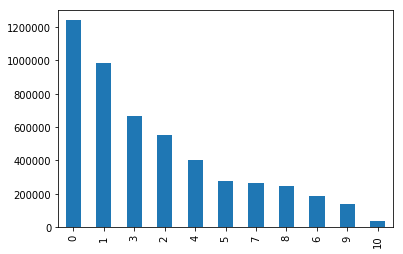

In [21]:
train.open_channels.value_counts().plot(kind='bar')

In [24]:
d_tr={}
d_val={}
for i, (tr_ind, val_ind) in enumerate(stratified_group_k_fold(train_x, train_y, groups, k=5)):
    d_tr.update({i: tr_ind})
    d_val.update({i: val_ind})

In [38]:
# https://github.com/hsiaocy/Beads/blob/master/beads.py
from scipy.sparse import spdiags


def beads(y, d, fc, r, lam0, lam1, lam2):
    # The following parameter may be altered.
    Nit = 3  # Nit: Number of iterations
    pen = 'L1_v2'  # pen : penalty function for sparse derivative ('L1_v1' or 'L1_v2')
    EPS0 = 1e-6  # cost smoothing parameter for x (small positive value)
    EPS1 = 1e-6  # cost smoothing parameter for derivatives(small positive value)

    if pen is 'L1_v1':
        phi = lambda xx: np.sqrt(np.power(abs(xx), 2) + EPS1)
        wfun = lambda xx: 1. / np.sqrt(np.power(abs(xx), 2) + EPS1)
    elif pen is 'L1_v2':
        phi = lambda xx: abs(xx) - EPS1 * np.log(abs(xx) + EPS1)
        wfun = lambda xx: 1. / (abs(xx) + EPS1)
    else:
        print('penalty must be L1_v1, L1_v2')
        x, cost, f = [], [], []
        return x, cost, f

    #  equation (25)
    theta = lambda xx: sum(xx[(xx > EPS0)]) - r * sum(xx[(xx < -EPS0)]) \
                       + sum((1+r)/(4*EPS0) * xx[abs(xx) <= EPS0] ** 2 \
                       + (1-r)/2 * xx[abs(xx) <= EPS0] + EPS0*(1+r)/4)

    y = np.reshape(a=y, newshape=(len(y), 1))
    x = y
    cost = []
    N = len(y)
    A, B = BAfilt(d, fc, N)
    H = lambda xx: np.dot(B, (linv(A, xx)))
    e = np.ones((N-1, 1))
    d1 = spdiags(np.array([-e, e]).squeeze(), np.array([0, 1]), N-1, N)
    d2 = spdiags(np.array([e, -2*e, e]).squeeze(), np.arange(0, 3), N-2, N)
    D1, D2 = d1.A, d2.A
    D1[-1, -1], D2[-1, -1] = 1., 1.
    D = np.vstack((D1, D2))
    BTB = np.dot(np.transpose(B), B)

    w = np.vstack(([lam1 * np.ones((N-1, 1)), lam2 * np.ones((N-2, 1))]))
    b = (1-r) / 2 * np.ones((N, 1))
    d = np.dot(BTB, (linv(A, y))) - lam0 * np.dot(np.transpose(A), b)

    gamma = np.ones((N, 1))

    for i in range(1, Nit+1):
        print('step: ', i)
        wf = wfun(np.dot(D, x))
        wff = w * wf
        lmda = spdiags(wff.transpose(), 0, 2 * N - 3, 2 * N - 3)
        Lmda = lmda.A

        k = np.array(abs(x) > EPS0)  # return index 1d
        gamma[~k] = ((1 + r) / 4) / abs(EPS0)
        gamma[k] = ((1 + r) / 4) / abs(x[k])
        Gamma = spdiags(gamma.transpose(), 0, N, N)

        M = 2 * lam0 * Gamma.A + np.dot(np.dot(np.transpose(D), Lmda), D).transpose()
        x = np.dot(A, np.linalg.solve(BTB + np.dot(np.dot(np.transpose(A), M), A), d))

        a = y - x
        cost.append(
            0.5 * sum(abs(H(a)) ** 2)
            + lam0 * theta(x)
            + lam1 * sum(phi(np.diff(x.squeeze())))
            + lam2 * sum(phi(np.diff(x.squeeze(), 2))))
        pass

    f = y - x - H(y - x)

    return x, cost, f

def BAfilt(d, fc, N):
    """
     --- local function ----
    function [A, B] = BAfilt(d, fc, N)
     [A, B] = BAfilt(d, fc, N)
     Banded matrices for zero-phase high-pass filter.
     The matrices are 'sparse' data type in MATLAB.
     INPUT
       d  : degree of filter is 2d (use d = 1 or 2)
       fc : cut-off frequency (normalized frequency, 0 < fc < 0.5)
       N  : length of signal
    """

    b1 = [1, -1]
    for i in range(1, d):
        b1 = np.convolve(a=b1, v=[-1, 2, -1])
    pass

    b = np.convolve(a=b1, v=[-1, 1])

    omc = 2 * np.pi * fc
    t = np.power(((1 - np.cos(omc)) / (1 + np.cos(omc))), d)

    a = 1
    for i in range(1, d+1):  # for i = 1:d
        a = np.convolve(a=a, v=[1, 2, 1])
    pass
    a = b + t * a
    xa, xb = (a*np.ones((N, 1))).transpose(), (b*np.ones((N, 1))).transpose()
    dr = np.arange(-d, d+1)
    A = spdiags(xa, dr, N, N)  # A: Symmetric banded matrix
    B = spdiags(xb, dr, N, N)  # B: banded matrix
    return A.A, B.A
    pass


# left inverse
def linv(a, b):
    return np.linalg.solve(a, b)


step:  1
step:  2
step:  3


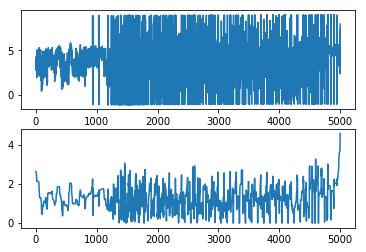

step:  1
step:  2
step:  3


In [45]:
sig = train.signal[3_642_000:(3_642_000+5000)].values

fc = 0.006
d = 1
r = 6
amp = 0.8
lam0 = 0.5 * amp
lam1 = 5 * amp
lam2 = 4 * amp
Nit = 1
pen = 'L1_v2'

# then do and plot
x, f, cost = beads(y=sig, d=d, fc=fc, r=r, lam0=lam0, lam1=lam1, lam2=lam2)
fig = plt.figure()
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
ax1.plot(sig)
ax2.plot(x)
plt.show()
x, cost, f = beads(y=sig, d=d, fc=fc, r=r, lam0=lam0, lam1=lam1, lam2=lam2)

In [47]:
x, sig

(array([[2.65225054],
        [2.64609015],
        [2.63956062],
        ...,
        [3.95337797],
        [4.27587122],
        [4.5988157 ]]),
 array([3.9906, 3.4692, 3.9119, ..., 2.3897, 5.2917, 7.9628]))

In [47]:
sig = train.signal.values[:5000].astype('float32')

step:  1
step:  2
step:  3


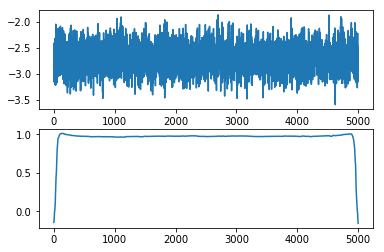

step:  1
step:  2
step:  3


In [48]:
fc = 0.006
d = 1
r = 6
amp = 0.8
lam0 = 0.5 * amp
lam1 = 5 * amp
lam2 = 4 * amp
Nit = 1
pen = 'L1_v2'

# then do and plot
x, f, cost = beads(y=sig, d=d, fc=fc, r=r, lam0=lam0, lam1=lam1, lam2=lam2)
fig = plt.figure()
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
ax1.plot(sig)
ax2.plot(x)
plt.show()
x, cost, f = beads(y=sig, d=d, fc=fc, r=r, lam0=lam0, lam1=lam1, lam2=lam2)
# print(x)

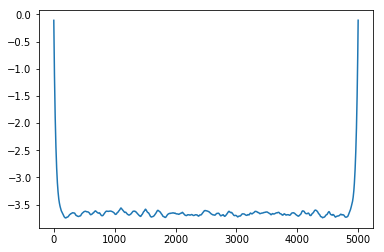

In [54]:
plt.plot(f)

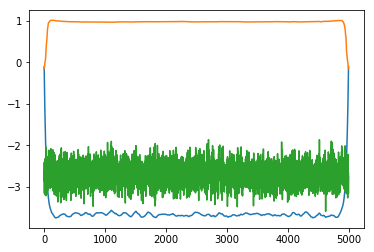

In [58]:
plt.plot(f)
plt.plot(x)
plt.plot(sig)

In [56]:
sig

array([-2.7597656, -2.8554688, -2.4082031, ..., -3.1523438, -2.7207031,
       -2.6738281], dtype=float32)

In [57]:
x

array([[-0.14513538],
       [-0.14264576],
       [-0.13759615],
       ...,
       [-0.1505332 ],
       [-0.15510096],
       [-0.1563256 ]])

In [68]:
from scipy import signal
def apply_convolution(sig, window):
    """Apply a simple same-size convolution with a given window size"""
    conv = np.repeat([0., 1., 0.], window)
    filtered = signal.convolve(sig, conv, mode='same') / window
    return filtered

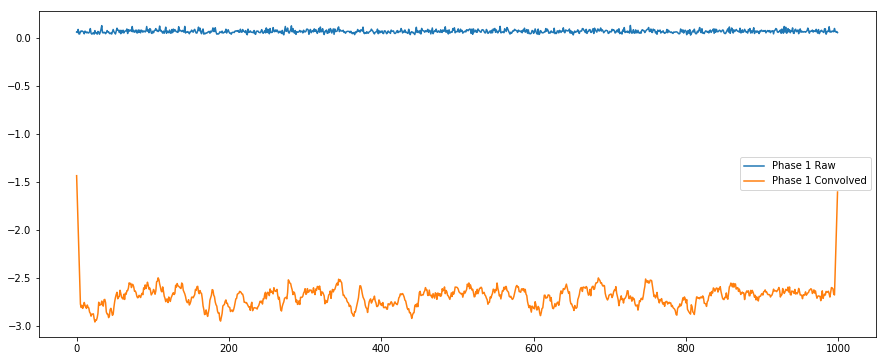

In [90]:
sig = train.signal.values[:1000]
convolved = apply_convolution(sig, 10)

plt.figure(figsize=(15, 6))

plt.plot(np.exp(sig), label='Phase 1 Raw')
# convolved = apply_convolution(sig, window)
plt.plot(convolved, label='Phase 1 Convolved')

plt.legend()

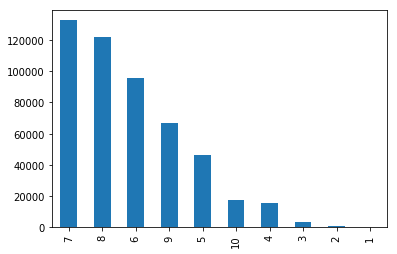

In [117]:
train[train.batch==9].open_channels.value_counts().plot(kind='bar')

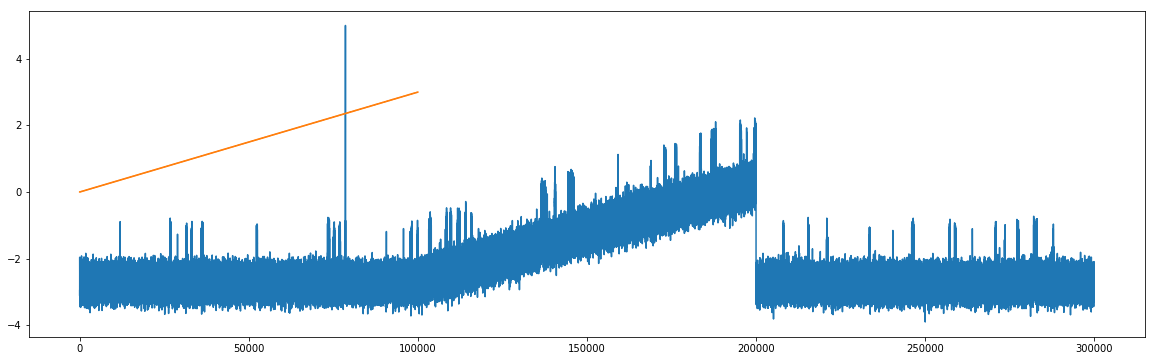

In [124]:
a = 500_000
b = 600_000

plt.figure(figsize=(20, 6))
# plt.plot(train.signal[a:b].values)

plt.plot(train.signal[(a-100_000): (b+100_000)].values)
plt.plot(3*(train.time.values[a:b] - 50)/10)

In [146]:
train.iloc[a:b, :].signal.max()

2.223

In [147]:
2.223*(train.time.values[a:b] - 50)/10

array([0.   , 0.   , 0.   , ..., 2.223, 2.223, 2.223], dtype=float16)

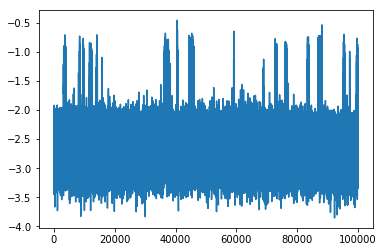

In [151]:
plt.plot(train.signal[a:b].values - 3*(train.time.values[a:b] - 50)/10)

In [157]:
train[train.batch==7].time.min()

350.0

In [158]:
from sklearn.linear_model import LinearRegression

In [164]:



X = train.time[a:b].values
X = np.reshape(X, (len(X), 1))
y = train.signal[a:b].values

model = LinearRegression()
model.fit(X, y)
# calculate trend
trend = model.predict(X)

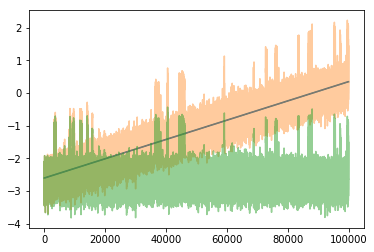

In [189]:
plt.plot(trend)
plt.plot(train.signal[a:b].values, alpha=.4)
plt.plot((y - trend)-2.60403825, alpha=.5)

In [185]:
np.mean(train.signal[a:(a+2)].values)

-3.191

In [187]:
np.mean((y - trend)[:2])

-0.58696175

In [191]:
3.191 - 0.58696175

2.60403825

In [192]:
train2 = train.copy()

In [203]:
train2.loc[train2.index[a:b], 'signal'] = (y - trend)-2.60403825

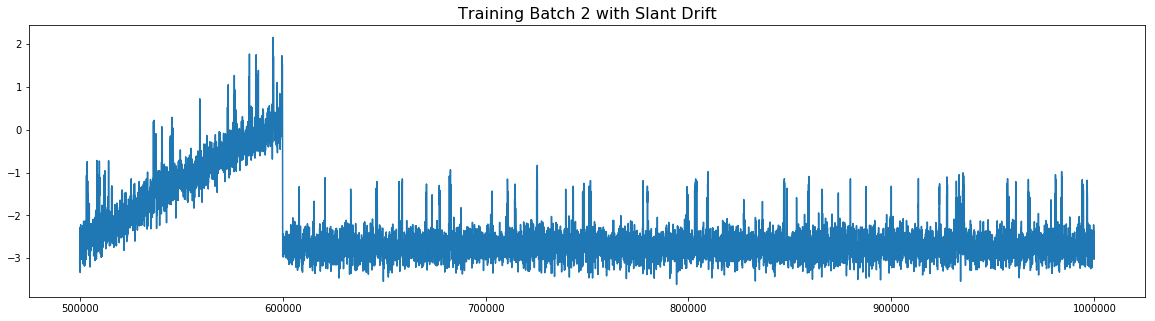

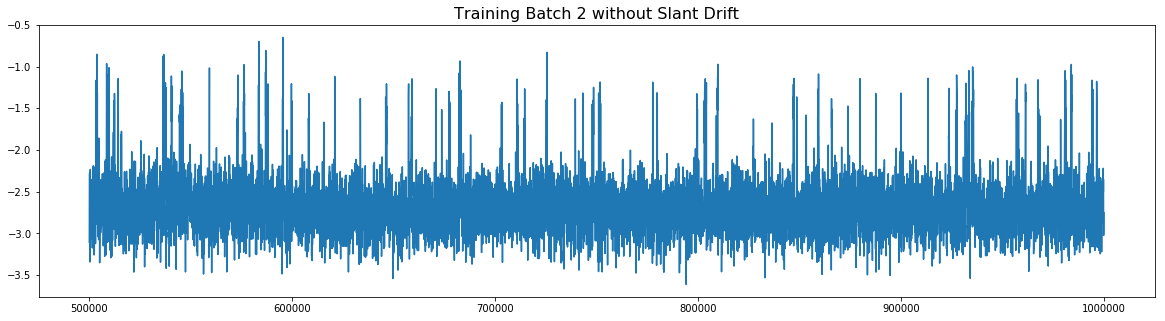

In [204]:
batch=2; a=500_000*(batch-1); b=500_000*batch; res=50
plt.figure(figsize=(20,5))
plt.plot(range(a,b,res),train.signal[a:b][0::res])
plt.title('Training Batch 2 with Slant Drift',size=16)
plt.figure(figsize=(20,5))
plt.plot(range(a,b,res),train2.signal[a:b][0::res])
plt.title('Training Batch 2 without Slant Drift',size=16)
plt.show()

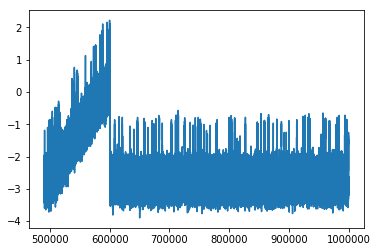

In [232]:
a = 500_000
b = 600_000
train.signal[(a-10000):(a*2)].plot()

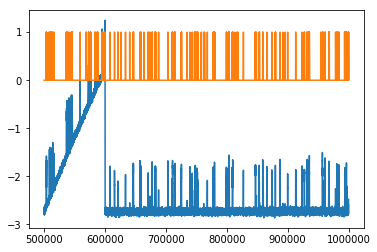

In [230]:
train.query("batch==1").signal.rolling(100).mean().plot()
train.query("batch==1").open_channels.plot()

In [231]:
def MACD(df, period1, period2, periodSignal):
    EMA1 = pd.DataFrame.ewm(df, span=period1).mean()
    EMA2 = pd.DataFrame.ewm(df, span=period2).mean()
    MACD = EMA1-EMA2
    
    Signal = pd.DataFrame.ewm(MACD,periodSignal).mean()
    
    Histogram = MACD-Signal
    
    return Histogram, Signal

def stochastics_oscillator(df,period):
    l, h = pd.DataFrame.rolling(df, period).min(), pd.DataFrame.rolling(df, period).max()
    k = 100 * (df - l) / (h - l)
    return k

In [265]:
h, s = MACD(train.query("batch==1").signal, 5, 10, 2)
h2, s2 = MACD(train2.query("batch==1").signal, 5, 10, 2)


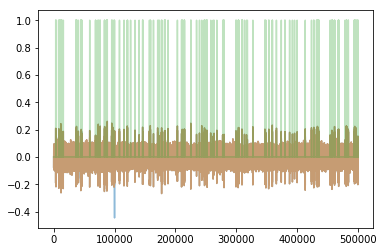

In [266]:
plt.plot(h.values, alpha=.5)
plt.plot(h2.values, alpha=.5)
plt.plot(train.query("batch==1").open_channels.values, alpha=.3)

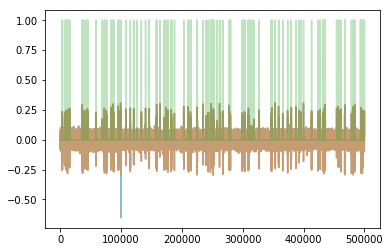

In [267]:
plt.plot(s.values, alpha=.5)
plt.plot(s2.values, alpha=.5)
plt.plot(train.query("batch==1").open_channels.values, alpha=.3)

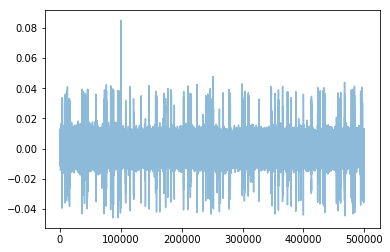

In [244]:
plt.plot(h.values, alpha=.5)

In [255]:
train.query("batch==1").signal

500000   -3.109375
500001   -3.273438
500002   -3.230469
500003   -3.048828
500004   -3.078125
            ...   
999995   -2.738281
999996   -1.764648
999997   -2.423828
999998   -1.764648
999999   -2.423828
Name: signal, Length: 500000, dtype: float16

In [290]:
t = train.query("batch==1").signal.rolling(5).min().dropna()
t2 = train2.query("batch==1").signal.rolling(5).min().dropna()

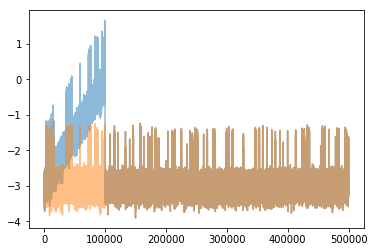

In [291]:
plt.plot(t.values, alpha=.5)
plt.plot(t2.values, alpha=.5)
# plt.plot(train.query("batch==1").open_channels.values, alpha=.3)

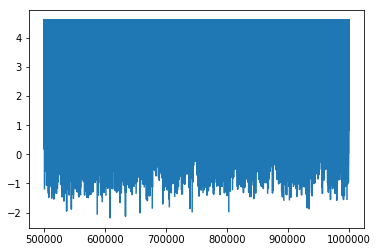

In [282]:
plt.plot(np.log(stoch2.dropna()))

In [ ]:
from numba import njit

In [314]:
tmp_lst=np.zeros_like(t)
for i in t.index.values[:10]:
    if t[i] < t[i+1]:
        np.append(tmp_lst, i)
    else:
        break

In [318]:
for i in t.index.values[:10]:
    print(t[i+1])

-3.2734375
-3.23046875
-3.078125
-3.078125
-3.05859375
-3.05859375
-3.05859375
-3.05859375
-3.05859375
-2.94921875


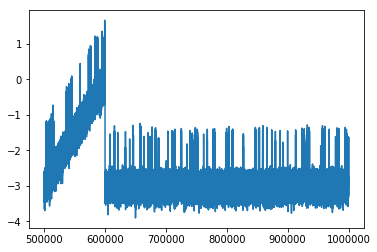

In [304]:
plt.plot(t)

In [319]:
train_clean = pd.read_csv('../data/wavenet_cleaned_kalman/train_clean_kalman.csv')

In [320]:
train_clean

,time,signal,open_channels
0,0.0001,-2.760655,0
1,0.0002,-2.848034,0
2,0.0003,-2.424341,0
3,0.0004,-3.130037,0
4,0.0005,-3.144854,0
...,...,...,...
4999995,499.9996,2.937281,7
4999996,499.9997,2.727728,7
4999997,499.9998,4.506354,8
4999998,499.9999,5.619422,9


In [ ]:
# https://github.com/RichardBJ/Deep-Channel/blob/master/deepchannel_train.py

def pytorch_model_run_cv(x_train,y_train,features,x_test, model_obj, feats = False,clip = True):
    seed_everything()
    avg_losses_f = []
    avg_val_losses_f = []
    # matrix for the out-of-fold predictions
    train_preds = np.zeros((len(x_train)))
    # matrix for the predictions on the test set
    test_preds = np.zeros((len(x_test)))
    splits = list(StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED).split(x_train, y_train))
    for i, (train_idx, valid_idx) in enumerate(splits):
        seed_everything(i*1000+i)
        x_train = np.array(x_train)
        y_train = np.array(y_train)
        if feats:
            features = np.array(features)
        x_train_fold = torch.tensor(x_train[train_idx.astype(int)], dtype=torch.long).cuda()
        y_train_fold = torch.tensor(y_train[train_idx.astype(int), np.newaxis], dtype=torch.float32).cuda()
        if feats:
            kfold_X_features = features[train_idx.astype(int)]
            kfold_X_valid_features = features[valid_idx.astype(int)]
        x_val_fold = torch.tensor(x_train[valid_idx.astype(int)], dtype=torch.long).cuda()
        y_val_fold = torch.tensor(y_train[valid_idx.astype(int), np.newaxis], dtype=torch.float32).cuda()

        model = copy.deepcopy(model_obj)

        model.cuda()

        loss_fn = torch.nn.BCEWithLogitsLoss(reduction='sum')

        step_size = 300
        base_lr, max_lr = 0.001, 0.003   
        optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), 
                                 lr=max_lr)

        ################################################################################################
        scheduler = CyclicLR(optimizer, base_lr=base_lr, max_lr=max_lr,
                   step_size=step_size, mode='exp_range',
                   gamma=0.99994)
        ###############################################################################################

        train = MyDataset(torch.utils.data.TensorDataset(x_train_fold, y_train_fold))
        valid = MyDataset(torch.utils.data.TensorDataset(x_val_fold, y_val_fold))

        train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
        valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)

        print(f'Fold {i + 1}')
        for epoch in range(n_epochs):
            start_time = time.time()
            model.train()

            avg_loss = 0.  
            for i, (x_batch, y_batch, index) in enumerate(train_loader):
                if feats:       
                    f = kfold_X_features[index]
                    y_pred = model([x_batch,f])
                else:
                    y_pred = model(x_batch)

                if scheduler:
                    scheduler.batch_step()

                # Compute and print loss.
                loss = loss_fn(y_pred, y_batch)
                optimizer.zero_grad()
                loss.backward()
                if clip:
                    nn.utils.clip_grad_norm_(model.parameters(),1)
                optimizer.step()
                avg_loss += loss.item() / len(train_loader)

            model.eval()

            valid_preds_fold = np.zeros((x_val_fold.size(0)))
            test_preds_fold = np.zeros((len(x_test)))

            avg_val_loss = 0.
            for i, (x_batch, y_batch,index) in enumerate(valid_loader):
                if feats:
                    f = kfold_X_valid_features[index]            
                    y_pred = model([x_batch,f]).detach()
                else:
                    y_pred = model(x_batch).detach()

                avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
                valid_preds_fold[index] = sigmoid(y_pred.cpu().numpy())[:, 0]

            elapsed_time = time.time() - start_time 
            print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f} \t time={:.2f}s'.format(
                epoch + 1, n_epochs, avg_loss, avg_val_loss, elapsed_time))
        avg_losses_f.append(avg_loss)
        avg_val_losses_f.append(avg_val_loss) 
        # predict all samples in the test set batch per batch
        for i, (x_batch,) in enumerate(test_loader):
            if feats:
                f = test_features[i * batch_size:(i+1) * batch_size]
                y_pred = model([x_batch,f]).detach()
            else:
                y_pred = model(x_batch).detach()

            test_preds_fold[i * batch_size:(i+1) * batch_size] = sigmoid(y_pred.cpu().numpy())[:, 0]

        train_preds[valid_idx] = valid_preds_fold
        test_preds += test_preds_fold / len(splits)

    print('All \t loss={:.4f} \t val_loss={:.4f} \t '.format(np.average(avg_losses_f),np.average(avg_val_losses_f)))
    return train_preds, test_preds

In [ ]:
# https://discuss.pytorch.org/t/any-pytorch-function-can-work-as-keras-timedistributed/1346/3
# https://github.com/SeanNaren/deepspeech.pytorch/blob/master/model.py

class TimeDistributed(nn.Module):
    def __init__(self, module, batch_first=False):
        super(TimeDistributed, self).__init__()
        self.module = module
        self.batch_first = batch_first

    def forward(self, x):

        if len(x.size()) <= 2:
            return self.module(x)

        # Squash samples and timesteps into a single axis
        x_reshape = x.contiguous().view(-1, x.size(-1))  # (samples * timesteps, input_size)

        y = self.module(x_reshape)

        # We have to reshape Y
        if self.batch_first:
            y = y.contiguous().view(x.size(0), -1, y.size(-1))  # (samples, timesteps, output_size)
        else:
            y = y.view(-1, x.size(1), y.size(-1))  # (timesteps, samples, output_size)

        return y
    


In [ ]:
class SequenceWise(nn.Module):
    def __init__(self, module):
        """
        Collapses input of dim T*N*H to (T*N)*H, and applies to a module.
        Allows handling of variable sequence lengths and minibatch sizes.
        :param module: Module to apply input to.
        """
        super(SequenceWise, self).__init__()
        self.module = module

    def forward(self, x):
        t, n = x.size(0), x.size(1)
        x = x.view(t * n, -1)
        x = self.module(x)
        x = x.view(t, n, -1)
        return x

    def __repr__(self):
        tmpstr = self.__class__.__name__ + ' (\n'
        tmpstr += self.module.__repr__()
        tmpstr += ')'
        return tmpstr

In [ ]:
class CRNN(nn.Module):
    def init(self):
        super(CRNN, self).init()
            # 1D CovNet for learning the Spectral features
            self.conv1 = nn.Conv1d(in_channels=1, out_channels=128, kernel_size=(32,))
            self.bn1 = nn.BatchNorm1d(128)
            self.maxpool1 = nn.MaxPool1d(kernel_size=1, stride=97)
            self.dropout1 = nn.Dropout(0.3)
            # 1D LSTM for learning the temporal aggregation
            self.lstm = nn.LSTM(input_size=128, hidden_size=128, num_layers=2, dropout=0.3)
            # Fully Connected layer
            #self.fc3 = nn.Linear(128, 128)
            #self.bn3 = nn.BatchNorm1d(128)
            # Get posterior probability for target event class
            self.fc4 = nn.Linear(128, 1)
            self.timedist = TimeDistributed(self.fc4)

In [5]:
train = pd.read_csv('../data/train.csv')

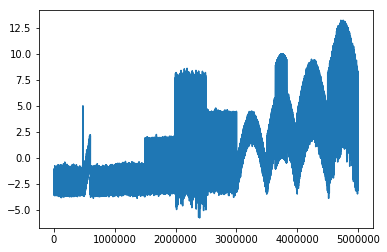

In [7]:
train.signal.plot()

In [25]:
td = TrendDecompose(10)
x=td.decompose(train.signal.head(1000_000))

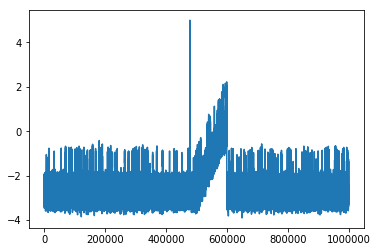

In [15]:
plt.plot(train.signal.head(1000_000))

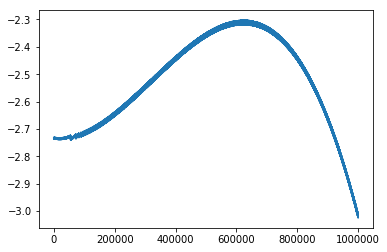

In [26]:
plt.plot(x)

In [4]:
import pandas as pd

from sklearn.linear_model import LinearRegression

class TrendDecompose(object):
    def __init__(self, trend_rate):
        self.trend_rate = trend_rate
        
        self.coefs = None
        self.trend_model = None
        
        self.mean = None
        self.std = None
        
    def decompose(self, X):
        df = pd.DataFrame({
            'time_series':X,
            'k_1':range(len(X))
        })
        for i in range(1,self.trend_rate):
            df['k_'+str(i+1)] = df['k_1']**(i+1)
        
        self.mean = df.mean()
        self.std = df.std()        
        df = (df - self.mean) / self.std
        
        model = LinearRegression()
        model.fit(df.drop(columns='time_series'), df['time_series'])
            
        self.coefs = [model.intercept_] + list(model.coef_)
        
        self.trend_model = lambda x: model.predict(x) * self.std['time_series'] + self.mean['time_series']
        
        return model.predict(df.drop(columns='time_series')) * self.std['time_series'] + self.mean['time_series']
    
    def decompose_extr(self, X):
        df = pd.DataFrame({
            'time_series':[0]*len(X),
            'k_1':X
        })
        
        for i in range(1,self.trend_rate):
            df['k_'+str(i+1)] = df['k_1']**(i+1)
            
        df = (df - self.mean)/self.std
            
        return self.trend_model(df.drop(columns='time_series'))

In [30]:
# https://www.kaggle.com/fkubota/clean-batch7-signal
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [60]:
def group_feat_train(_train):
    train = _train.copy()
    # group init
    train['group'] = int(0)

    # group 1
    idxs = (train['batch'] == 3) | (train['batch'] == 7)
    train['group'][idxs] = int(1)

    # group 2
    idxs = (train['batch'] == 5) | (train['batch'] == 8)
    train['group'][idxs] = int(2)

    # group 3
    idxs = (train['batch'] == 2) | (train['batch'] == 6)
    train['group'][idxs] = int(3)

    # group 4
    idxs = (train['batch'] == 4) | (train['batch'] == 9)
    train['group'][idxs] = int(4)
    
    return train[['group']]

In [34]:
batch_list = []
for n in range(10):
    batchs = np.ones(500000)*n
    batch_list.append(batchs.astype(int))
batch_list = np.hstack(batch_list)
train['batch'] = batch_list

In [36]:
group = group_feat_train(train)
train = pd.concat([train, group], axis=1)

In [38]:
train['mean_sig'] = train.groupby(['open_channels','batch'])['signal'].transform('mean')

Text(0, 0.5, 'signal')

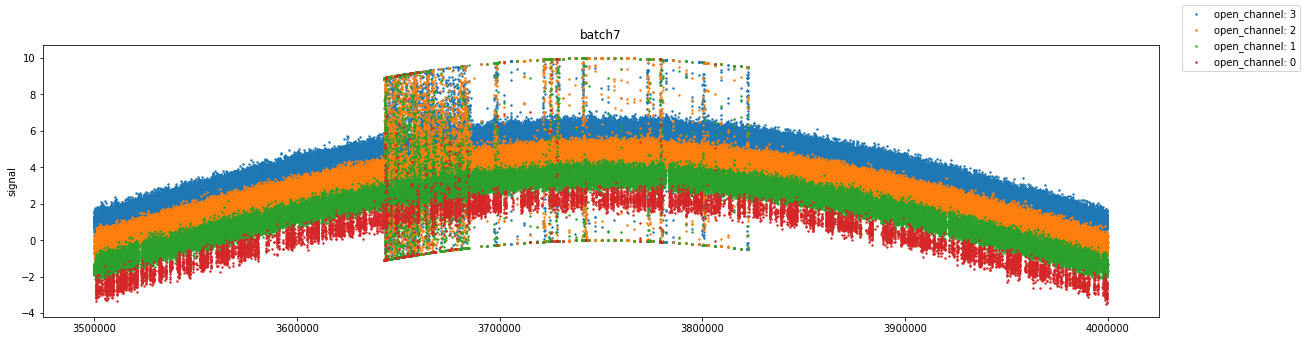

In [41]:
res = 100
x = np.arange(len(train))

fig = plt.figure(figsize=(20, 5))
for i in train[train['batch']==7]['open_channels'].unique():
    idxs = (train['batch'] == 7) & (train['open_channels'].values==i)
    plt.scatter(x[idxs], train['signal'].values[idxs], s=2, label=f'open_channel: {i}')
    
fig.legend(fontsize=10)
plt.title('batch7')
plt.ylabel('signal')

Text(0, 0.5, 'signal')

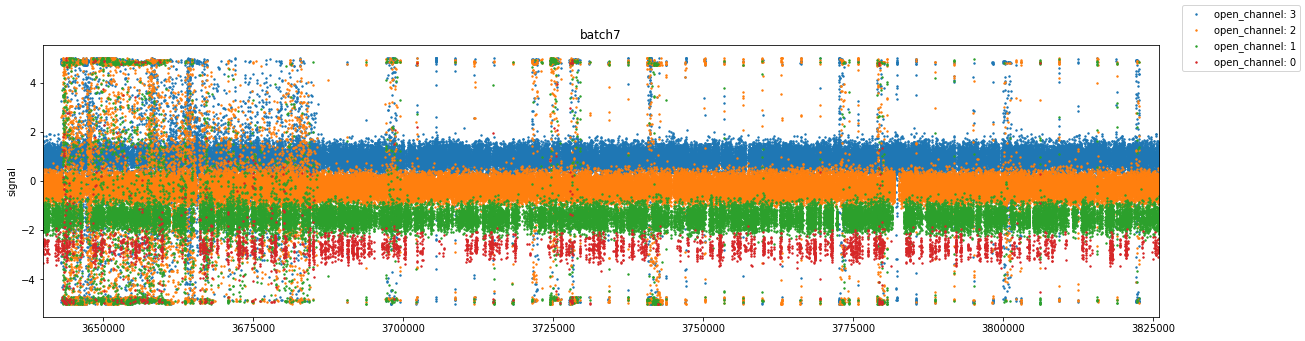

In [62]:
train = pd.read_csv('../data/cleaned/train.csv')

batch_list = []
for n in range(10):
    batchs = np.ones(500000)*n
    batch_list.append(batchs.astype(int))
batch_list = np.hstack(batch_list)
train['batch'] = batch_list

group = group_feat_train(train)
train = pd.concat([train, group], axis=1)

train['mean_sig'] = train.groupby(['open_channels','batch'])['signal'].transform('mean')

## plot without drift
res = 100
x = np.arange(len(train))

fig = plt.figure(figsize=(20, 5))
for i in train[train['batch']==7]['open_channels'].unique():
    idxs = (train['batch'] == 7) & (train['open_channels'].values==i)
    plt.scatter(x[idxs], train['signal'].values[idxs], s=2, label=f'open_channel: {i}')
    
fig.legend(fontsize=10)
plt.xlim(3_640_000, 3_826_000)
plt.title('batch7')
plt.ylabel('signal')

In [45]:
left = 3_641_000
right = 3_829_000

# batch7 signal mean (without noisy area)
idxs_noisy = (train['open_channels']==3) & (left<train.index) & (train.index<right)
idxs_not_noisy = (train['open_channels']==3) & ~idxs_noisy

In [46]:
# Determine the threshold for outliers.
# In this case, the threshold was determined by eye measurement.
thresh_high = 2.0
thresh_low = 0.1

In [47]:
# batch7 signal mean (without noisy area)
idxs_noisy = (train['open_channels']==3) & (left<train.index) & (train.index<right)
idxs_not_noisy = (train['open_channels']==3) & ~idxs_noisy
mean = train[idxs_not_noisy]['signal'].mean()

In [49]:
# replace the outlier with the average value

train['signal_mod'] = train['signal'].values

idxs_outlier = idxs_noisy & (thresh_high<train['signal'].values)
train['signal_mod'][idxs_outlier]  = mean
idxs_outlier = idxs_noisy & (train['signal'].values<thresh_low)
train['signal_mod'][idxs_outlier]  = mean

In [59]:
3829000-3641000

188000

In [50]:
def create_signal_mod(train):
    left = 3641000
    right = 3829000
    thresh_dict = {
        3: [0.1, 2.0],
        2: [-1.1, 0.7],
        1: [-2.3, -0.6],
        0: [-3.8, -2],
    }
    
    train['signal_mod'] = train['signal'].values
    for ch in train[train['batch']==7]['open_channels'].unique():
        idxs_noisy = (train['open_channels']==ch) & (left<train.index) & (train.index<right)
        idxs_not_noisy = (train['open_channels']==ch) & ~idxs_noisy
        mean = train[idxs_not_noisy]['signal'].mean()

        idxs_outlier = idxs_noisy & (thresh_dict[ch][1]<train['signal'].values)
        train['signal_mod'][idxs_outlier]  = mean
        idxs_outlier = idxs_noisy & (train['signal'].values<thresh_dict[ch][0])
        train['signal_mod'][idxs_outlier]  = mean
    return train

train = create_signal_mod(train)

Text(0, 0.5, 'signal')

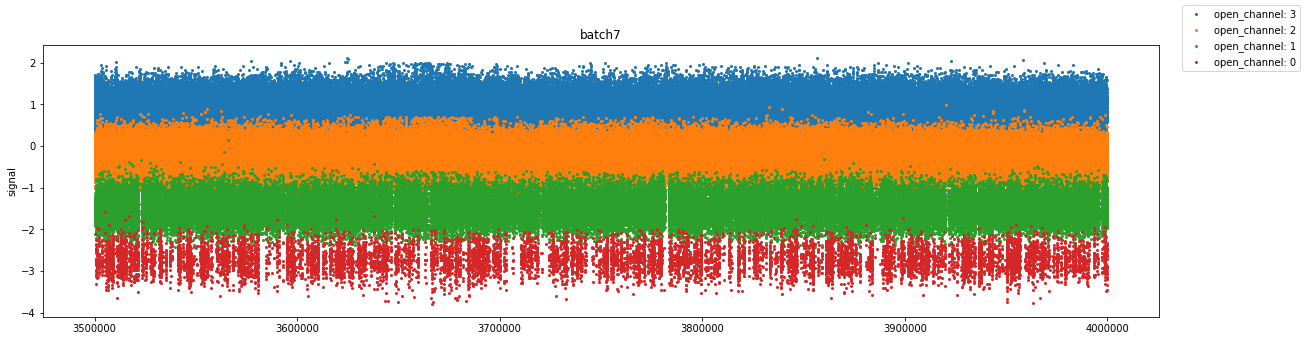

In [52]:
res = 100
x = np.arange(len(train))

fig = plt.figure(figsize=(20, 5))
for i in train[train['batch']==7]['open_channels'].unique():
# for i in [0]:
    idxs = (train['batch'] == 7) & (train['open_channels'].values==i)
    plt.scatter(x[idxs], train['signal_mod'].values[idxs], s=4, label=f'open_channel: {i}')
    
    
fig.legend(fontsize=10)
plt.title('batch7')
plt.ylabel('signal')

In [53]:
train['signal'] = train['signal_mod']

,time,signal,open_channels,batch,group,mean_sig,signal_mod
0,0.0001,-2.7607,0,0,0,-2.720454,-2.7607
1,0.0002,-2.8480,0,0,0,-2.720454,-2.8480
2,0.0003,-2.4243,0,0,0,-2.720454,-2.4243
3,0.0004,-3.1300,0,0,0,-2.720454,-3.1300
4,0.0005,-3.1449,0,0,0,-2.720454,-3.1449
...,...,...,...,...,...,...,...
4999995,499.9996,2.9373,7,9,4,3.175041,2.9373
4999996,499.9997,2.7277,7,9,4,3.175041,2.7277
4999997,499.9998,4.5064,8,9,4,4.398595,4.5064
4999998,499.9999,5.6194,9,9,4,5.621944,5.6194


In [55]:
# https://www.kaggle.com/nischaydnk/ion-switching-with-rapids-visualization
train = pd.read_csv('../data/cleaned/train.csv')
train['batches'] = (train.index // 500_000) + 1
train['group'] = -1
x = [(0,500000),(1000000,1500000),(1500000,2000000),(2500000,3000000),(2000000,2500000)]

In [57]:
test = pd.read_csv('../data/cleaned/test.csv')
test['group'] = -1
x = [[(0,100000),(300000,400000),(800000,900000),(1000000,2000000)],[(400000,500000)], 
     [(100000,200000),(900000,1000000)],[(200000,300000),(600000,700000)],[(500000,600000),(700000,800000)]]
for k in range(5):
    for j in range(len(x[k])): test.iloc[x[k][j][0]:x[k][j][1],2] = k

In [58]:
test

,time,signal,group
0,500.0001,-2.6513,0
1,500.0002,-2.8466,0
2,500.0003,-2.8538,0
3,500.0004,-2.4438,0
4,500.0005,-2.6125,0
...,...,...,...
1999995,699.9996,-2.9056,0
1999996,699.9997,-2.7458,0
1999997,699.9998,-2.8284,0
1999998,699.9999,-2.9056,0


In [85]:
train.iloc[3:5, :]

,time,signal,open_channels,batches
3,0.0004,-3.1300,0,0
4,0.0005,-3.1449,0,0


In [65]:
train = pd.read_csv('../data/cleaned/train.csv')
train['batches'] = (train.index // 500_000)

In [155]:
left = 3_642_000
right = 3_825_000
low = -3.8
upper = 2

In [167]:
nois_ind = train.loc[3642000:3825000, :].index

In [175]:
ind_to_nan = train.iloc[nois_ind][(train.signal>upper) | (train.signal<low)].signal.index

In [180]:
train.loc[ind_to_nan, 'signal'] = np.nan